<a href="https://colab.research.google.com/github/AlanMarquesRocha/t02_ica_rna_mlp_rbf/blob/master/t02_ica_rna_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### Programa de Pós-Graduação em Engenharia Elétrica e de Computação (PPGEEC)
### Ingeligência Computacional Aplicada (ICA)
### Trabalho 02 - Redes Neurais Artificiais Perceptron Multicamadas (RNA - MLP) e Redes de Base Radial (RBF)
### Base de dados: ``Predict Students' dropout and academic sucess``
### Discente: Alan Marques da Rocha (543897)
---

#### O conjunto de dados ``Predict Students' dropout and academic sucess`` contém 4.424 instâncias, 36 atributos e três classes distintas, a saber: ``Dropout``, ``Graduate`` e ``Enrolled``.

#### O arquivo está em formato ``.csv`` e pode ser acessado através de um programa de planilhas comum (Excel, calc, Planilhas Google, etc..)

#### A base de dados foi dividida em 80% para treino e 20% para teste.

# **Implementação da ``Rede Neural Artificial Perceptron de Múltiplas camadas``**

### 1ª etapa: Importando as bibliotecas necessárias para a implementação do algoritmo

In [1]:
# importando as bibliotecas de manipulação de dados
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

# bibliotecas para normalização e balanceamento dos dados
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import StratifiedKFold
from statistics import mean, stdev
from sklearn.model_selection import cross_val_score
# from imblearn.over_sampling import SMOTE
from collections import Counter

# biblioteca para divisão do dataset em treino/teste
# from sklearn.model_selection import train_test_split

# bibliotecas para a implementação da MLP
from sklearn.neural_network import MLPClassifier

# bibliotecas para verificação das métricas da MLP
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

### 2ª etapa: Abertura da base de dados com ``pandas``

#### A coluna ``target`` possui as seguintes informações:

- Graduate
- Enrolled
- Dropout

#### Houveram as seguintes modificações nas classes:

- Graduate = 1
- Enrolled = 0
- Dropout = -1

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp -R /content/gdrive/MyDrive/cursos/ica_ppgeec/t02_ica_rna_mlp_rbf code/

Mounted at /content/gdrive


In [3]:
# Abrindo o arquivo diretamento do diretório:
data = pd.read_csv('/content/code/data.csv', sep=';')

data.head(3)

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0,0,10.8,1.4,1.74,-1
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,0,6,6,6,0,13.9,-0.3,0.79,1
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,0,6,0,0,0,10.8,1.4,1.74,-1


### **3ª etapa: Pré-Processamento dos Dados:**

#### Definindo o conjunto de atributos/instâncias e suas respectivas classes:

In [4]:
# definindo os atributos do dataset:
X = data.drop(['Target'], axis = 1)

# definindo as classes:
y = data.Target

#### 3.1 Algumas informações do dataset

In [5]:
# Informa o n° presente de cada classe no dataset:
data['Target'].value_counts()

 1    2209
-1    1421
 0     794
Name: Target, dtype: int64

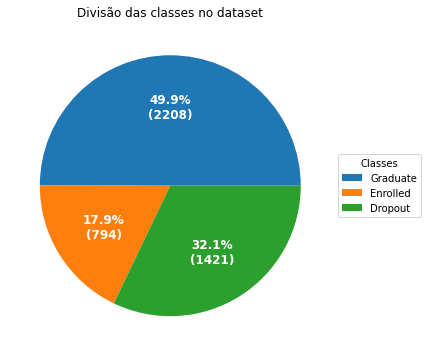

In [6]:
# Área que plota-se o gráfico e define-se o seu tamanho
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect="equal"))

# Informações das classes
recipe = ["Graduate",
          "Enrolled",
          "Dropout"]

# Informa-se a quantidade dos dados
data_class = [2209, 794, 1421]

# Mostra a porcentagem de cada classe no dataset
def func(pct, allvals):
    # calc %
    absolute = int(pct/100.*np.sum(allvals))
    # fazendo legenda do gráfico
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Criando o gráfico e colocando a função da legenda interna
wedges, texts, autotexts = ax.pie(data_class, autopct = lambda pct: func(pct, data_class),
                                  textprops=dict(color = "w"))

# Definindo a caixa de legenda externa, título, localização e onde vai 'ancorar o box'
ax.legend(wedges, recipe,
          title="Classes",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Aqui definimos o tamanho do texto de dentro do gráfico, e o peso da fonte como bold
plt.setp(autotexts, size=12, weight="bold")

# Título do gráfico
ax.set_title("Divisão das classes no dataset")

# Mostrando o gráfico
plt.show()

#### 3.1 Realizando a normalização dos dados antes da validação cruzada dos conjuntos de treino/teste:

#### Para padronizar os dados no intervalo (-1, 1), foi utilizado o ``MaxAbsScaler``.

In [7]:
# Tipo de normalizador de dados.
norm = MaxAbsScaler()

scaler = norm.fit(X) # Calcula o máximo de cada atributo

# Dados dos atributos normalizados
X_norm = scaler.transform(X)

X_norm

array([[ 0.16666667,  0.29824561,  0.55555556, ...,  0.66666667,
         0.37837838,  0.42857143],
       [ 0.16666667,  0.26315789,  0.11111111, ...,  0.85802469,
        -0.08108108,  0.19458128],
       [ 0.16666667,  0.01754386,  0.55555556, ...,  0.66666667,
         0.37837838,  0.42857143],
       ...,
       [ 0.16666667,  0.01754386,  0.11111111, ...,  0.85802469,
        -0.08108108,  0.19458128],
       [ 0.16666667,  0.01754386,  0.11111111, ...,  0.58024691,
        -0.21621622, -0.76847291],
       [ 0.16666667,  0.1754386 ,  0.11111111, ...,  0.78395062,
         1.        , -0.41871921]])

#### 3.2 Validação cruzada estratificada com ``StratifiedKFold``.

Essa classe de validação cruzada é uma variação do ``KFold`` que retorna amostras estratificadas. As amostras são divididas **preservando a porcentagem de amostras para cada classe**.



##### 3.2.1 Características da classe ``StratifiedKFold``:

- ``n_splits (int)`` = n° de ``folds``
- ``shuffle (double)`` = Define se as amostras de cada classe devem ser embaralhadas antes de serem divididas em lotes
- ``random_state (int)`` = Quando ``shuffle`` for ``True``, ``random_state`` afeta a ordenação dos índices, que controla a aleatoriedade de cada ``fold`` para cada classe.


In [8]:
splits = 5
skf = StratifiedKFold(n_splits = splits, shuffle=True, random_state=1)

# lista que receberá as acurácias do modelo MLP
mlp_list_1 = []
mlp_list_2 = []
mlp_list_3 = []


### 4. Construindo a RNA-MLP:

#### 4.1 Características da RNA MLP:

- ``hidden_layer_sizes`` = n° de camadas ocultas (tupla)
- ``tol`` = tolerância de convergência do algoritmo
- ``learning_rate_init`` = taxa de aprendizagem
- ``solver`` = O solucionador para otimização de peso (Ex: 'lbfgs', 'sgd', 'adam'), default='adam')
- ``activation`` = Função de ativação para a camada oculta (Ex: ‘identity’, ‘logistic’, ‘tanh’, ‘relu’), default=’relu’
- ``learning_rate`` = Cronograma de taxa de aprendizado para atualizações de peso (Ex: 'constant', 'invscaling', 'adaptive') default='constant'

In [9]:

# 1ª topologia utilizando a função de ativação ReLU.
model_1 = MLPClassifier(hidden_layer_sizes=(40,20), max_iter = 1000, activation = 'relu', solver = 'adam', tol = 0.0000001, random_state = 3);

# 2ª topologia utilizando a função de ativação tanh (tangente hiperbólica)
model_2 = MLPClassifier(hidden_layer_sizes=(40,20), max_iter = 1000, activation = 'tanh', solver = 'adam', tol = 0.0000001, random_state = 3);

# 3ª topologia utilizando a função de ativação logistic.
model_3 = MLPClassifier(hidden_layer_sizes=(40,20), max_iter = 1000, activation = 'logistic', solver = 'adam', tol = 0.0000001, random_state = 3);


### 5 Validação do modelo da RNA-MLP proposta:

#### 5.1 Processo de treinamento e teste dos modelos através dos ``folds``

In [10]:
def train_test_model(modelo, lista):
  # separação dos folds de cada modelo. 
  for train_index, test_index in skf.split(X_norm, y):
    x_train_fold, x_test_fold = X_norm[train_index], X_norm[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # treino e teste:
    modelo.fit(x_train_fold, y_train_fold);
    y_pred_1 = modelo.predict(x_test_fold)
    lista.append(modelo.score(x_test_fold, y_test_fold))
    
    # Imprime as matrizes de confusão para cada treino e teste do fold = k...k-1.
    def accuracy(confusion_matrix):
      diagonal_sum = confusion_matrix.trace()
      sum_of_all_elements = confusion_matrix.sum()
      return diagonal_sum / sum_of_all_elements

    fig = plot_confusion_matrix(modelo, x_test_fold, y_test_fold, display_labels = modelo.classes_)
    fig.figure_.suptitle("Matriz de confusão com Stratified Kfold")
    plt.show();

# Método que calcula a precisão dos modelos das redes MLP.
def results_model(modelo, lista):
  # Mostra o resultado das acurácias calculadas pelo modelo.
  print(' ------------------- Resultados obtidos do modelo 1 com função de ativação Relu --------------------- \n')
  print('Lista de possíveis acurácias do modelo: ', lista)
  print('\nAcurácia máxima que pode ser obtida por esse modelo: {:.2f}%'.format(max(lista)*100, '%'))
  print('\nAcurácia mínima: {:.2f}%'.format(min(lista)*100, '%'))
  print('\nAcurácia média do modelo: {:.2f}%'.format(mean(lista)*100, '%'))
  print('\nDesvio padrão:', stdev(lista))
  print('-----------------------------------------------------------------------------------------------------------------------------------\n')



#### 5.2 Matriz de Confusão e medidas de classificação da MLP

##### 5.2.1 **Matrizes de confusão e medidas de acurácia para o modelo 1 com função de ativação ``ReLu``**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


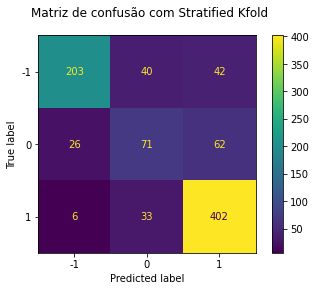

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


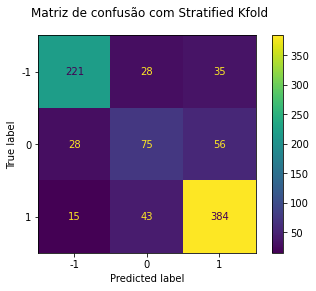

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


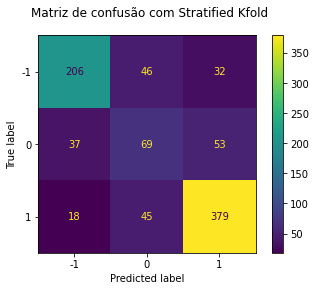

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


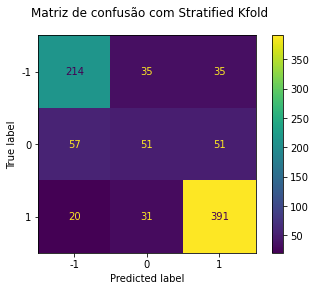

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


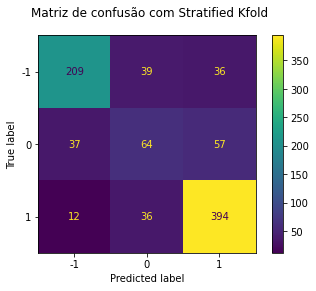

In [ ]:
train_test_model(model_1, mlp_list_1);

In [ ]:
results_model(model_1, mlp_list_1);

 ------------------- Resultados obtidos do modelo 1 com função de ativação Relu --------------------- 

Lista de possíveis acurácias do modelo:  [0.7638418079096045, 0.768361581920904, 0.7389830508474576, 0.7412429378531074, 0.754524886877828]

Acurácia máxima que pode ser obtida por esse modelo: 76.84%

Acurácia mínima: 73.90%

Acurácia média do modelo: 75.34%

Desvio padrão: 0.013131906002792855
-----------------------------------------------------------------------------------------------------------------------------------



##### 5.2.2 **Matrizes de confusão e medidas de acurácia para o modelo 2 com função de ativação ``tanh``**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


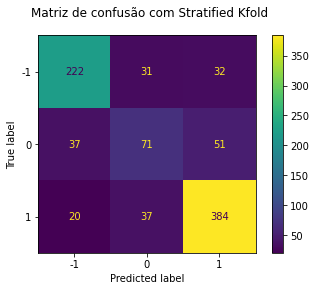

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


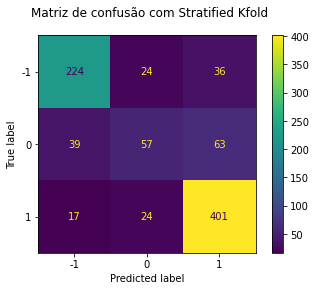

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


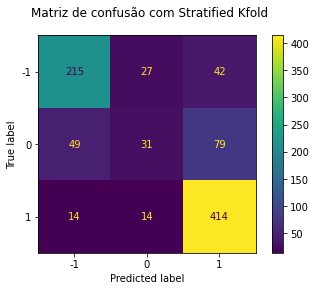

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


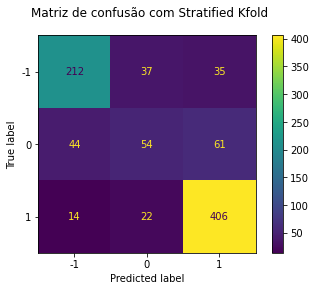

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


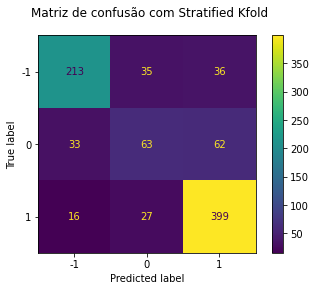

In [ ]:
train_test_model(model_2, mlp_list_2);

In [ ]:
results_model(model_2, mlp_list_2);

 ------------------- Resultados obtidos do modelo 1 com função de ativação Relu --------------------- 

Lista de possíveis acurácias do modelo:  [0.7649717514124293, 0.7706214689265537, 0.7457627118644068, 0.7593220338983051, 0.7635746606334841]

Acurácia máxima que pode ser obtida por esse modelo: 77.06%

Acurácia mínima: 74.58%

Acurácia média do modelo: 76.09%

Desvio padrão: 0.009352207728265538
-----------------------------------------------------------------------------------------------------------------------------------



##### 5.2.3 **Matrizes de confusão e medidas de acurárica para o modelo 3 com função de ativação ``logistic``**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


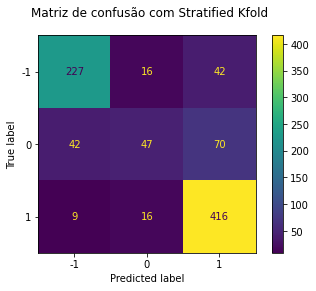

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


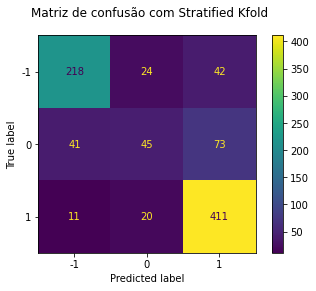

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


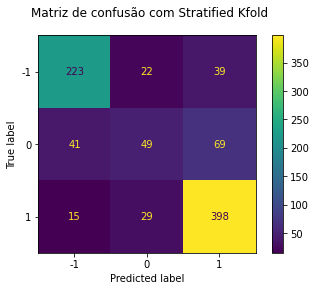

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


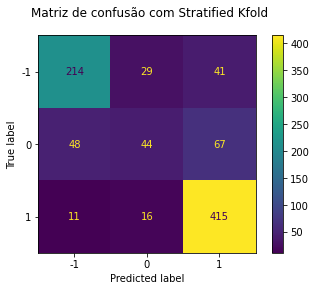

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


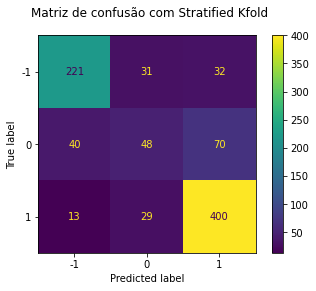

In [ ]:
train_test_model(model_3, mlp_list_3);

In [ ]:
results_model(model_3, mlp_list_3);

 ------------------- Resultados obtidos do modelo 1 com função de ativação Relu --------------------- 

Lista de possíveis acurácias do modelo:  [0.7796610169491526, 0.7615819209039548, 0.7570621468926554, 0.7604519774011299, 0.7567873303167421]

Acurácia máxima que pode ser obtida por esse modelo: 77.97%

Acurácia mínima: 75.68%

Acurácia média do modelo: 76.31%

Desvio padrão: 0.00948536958628556
-----------------------------------------------------------------------------------------------------------------------------------



#### 5.3 Plotando a curva da perda por interação:

In [ ]:
# Função de plota a curva da perda por interação de acordo com a especificação do modelo.
def loss_curve(modelo):
  loss_values = modelo.loss_curve_

  plt.plot(loss_values)
  plt.title("Loss Curve", fontsize=14)
  plt.xlabel('Interações')
  plt.ylabel('Custo')
  plt.show();

##### 5.4.1 **Resultado da curva para o modelo 1**

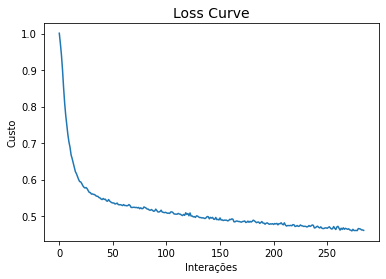

In [ ]:
loss_curve(model_1);

##### 5.4.2 **Resultado da curva para o modelo 2**

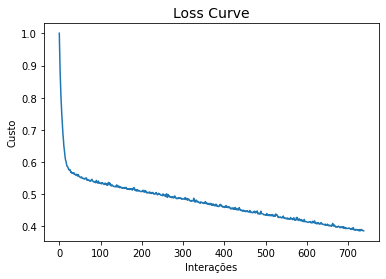

In [ ]:
loss_curve(model_2);

##### 5.4.3 **Resultado da curva para o modelo 3**

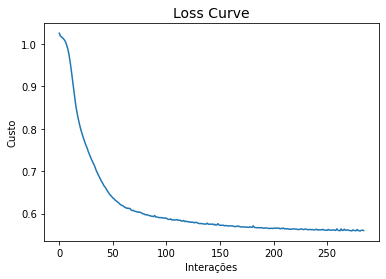

In [ ]:
loss_curve(model_3);